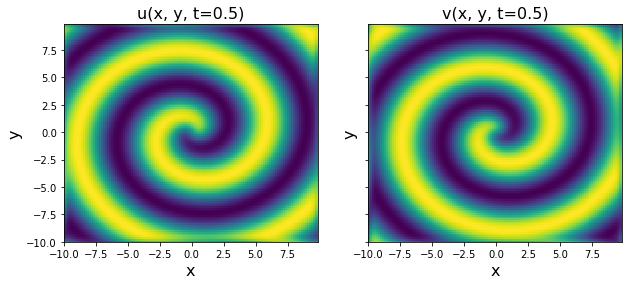

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12
from numpy.fft import fft2, ifft2
integrator_keywords['method'] = 'RK45'  # switch to RK45 integrator


# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs,
             -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
t = np.linspace(0, 10, int(10 / 0.05))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20  # Domain size in X and Y directions
n = 128  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2),
                                  np.linspace(-n2, -1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(fft2(u[:, :, 0]), (1, N)),
         np.reshape(fft2(v[:, :, 0]), (1, N)))
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t,
    args=(K22, d1, d2, beta, n, N), **integrator_keywords
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, t=0.5)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, t=0.5)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [2]:
# Compute u_t from generated solution
u = np.zeros((n, n, len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol
u_dot = ps.FiniteDifference(axis=2)._differentiate(u, dt)

# Choose 60 % of data for training because data is big...
# can only randomly subsample if you are passing u_dot to model.fit!!!
train = np.random.choice(len(t), int(len(t) * 0.6), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, :, train, :]
u_test = u[:, :, test, :]
u_dot_train = u_dot[:, :, train, :]
u_dot_test = u_dot[:, :, test, :]
t_train = t[train]
t_test = t[test]
spatial_grid = np.asarray([X, Y]).T

In [4]:
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5,
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_test)

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=60,
    max_iter=10,
    tol=1e-10,
    nu=1,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_sr3 = model.predict(u_test)

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=40,
    max_iter=10000,
    tol=1e-10,
    nu=1e2,
    thresholder="l1",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()

print('Constrained SR3 model, L0 norm: ')
feature_names = np.asarray(model.get_feature_names())
n_features = len(feature_names)
n_targets = u_train.shape[-1]
constraint_rhs = np.zeros(2)
constraint_lhs = np.zeros((2, n_targets * n_features))

# (u_xx coefficient) - (u_yy coefficient) = 0
constraint_lhs[0, 11] = 1
constraint_lhs[0, 15] = -1
# (v_xx coefficient) - (v_yy coefficient) = 0
constraint_lhs[1, n_features + 11] = 1
constraint_lhs[1, n_features + 15] = -1
optimizer = ps.ConstrainedSR3(
    threshold=.05,
    max_iter=400,
    tol=1e-10,
    nu=1,
    thresholder="l0",
    normalize_columns=False,
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_constrained_sr3 = model.predict(u_test)

STLSQ model: 
(x0)' = 1.114 x0 + -0.080 x1 + -1.104 x0x0x0 + 1.089 x1x1x1 + -1.103 x0x1x1 + 1.088 x0x0x1 + 0.121 x0_22 + 0.120 x0_11
(x1)' = 0.080 x0 + 1.114 x1 + -1.089 x0x0x0 + -1.104 x1x1x1 + -1.088 x0x1x1 + -1.104 x0x0x1 + 0.120 x1_22 + 0.121 x1_11
SR3 model, L0 norm: 


/Users/edwardmcdugald/.conda/envs/untitled/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 10 iterations.
  warnings.warn(


(x0)' = 1.114 x0 + -0.080 x1 + -1.104 x0x0x0 + 1.089 x1x1x1 + -1.103 x0x1x1 + 1.088 x0x0x1 + 0.121 x0_22 + 0.120 x0_11
(x1)' = 0.080 x0 + 1.114 x1 + -1.089 x0x0x0 + -1.104 x1x1x1 + -1.088 x0x1x1 + -1.104 x0x0x1 + 0.120 x1_22 + 0.121 x1_11
SR3 model, L1 norm: 
(x0)' = 1.096 x0 + -1.086 x0x0x0 + 1.000 x1x1x1 + -1.086 x0x1x1 + 1.000 x0x0x1 + 0.118 x0_22 + 0.118 x0_11
(x1)' = 1.096 x1 + -1.000 x0x0x0 + -1.086 x1x1x1 + -1.000 x0x1x1 + -1.086 x0x0x1 + 0.118 x1_22 + 0.118 x1_11
Constrained SR3 model, L0 norm: 
(x0)' = 0.753 x0 + 0.154 x1 + -0.755 x0x0x0 + 0.831 x1x1x1 + -0.757 x0x1x1 + 0.830 x0x0x1 + 0.096 x0_22 + 0.053 x0_1 + 0.053 x0_11 + -0.119 x0x0_2 + -0.289 x0x0x0x0_2 + 0.077 x1x1x1x1_2 + 0.072 x0x0x1x0_2 + -0.282 x1x1_22 + 0.153 x0x1x1x0_22 + 0.208 x0x0_1 + -0.088 x1x1_1 + -0.079 x1x1x1x0_1 + 0.127 x1x1x1x1_1 + -0.052 x0x0x1x0_1 + 0.313 x0x0x1x1_1 + 0.227 x0x0x0x0_12 + -0.072 x0x0x0x1_12 + 0.324 x0x1x1x0_12 + -0.306 x0x1x1x1_12 + -0.097 x0x0x1x1_12 + -0.066 x0x0_11 + -0.176 x1x0_11 + 0

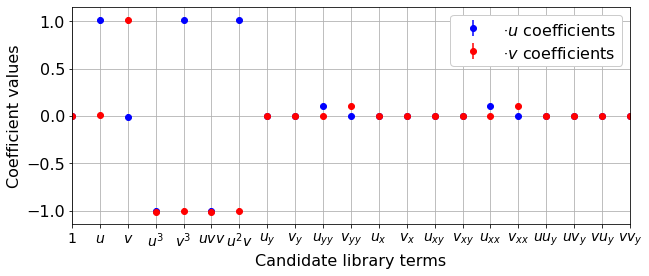

In [5]:
# Show boosting functionality with 2D PDEs where 1/3 the temporal data is used
optimizer = ps.STLSQ(threshold=40, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train,
          x_dot=u_dot_train,
          ensemble=True,
          n_models=10,
          n_subset=len(t_train) // 3
)
xticknames = model.get_feature_names()
num_ticks = len(xticknames)

# Plot boosting results with error bars
mean_coefs = np.mean(model.coef_list, axis=0)
std_coefs = np.std(model.coef_list, axis=0)
colors = ['b', 'r', 'k']
feature_names = ['u', 'v']
plt.figure(figsize=(10, 4))
for i in range(mean_coefs.shape[0]):
    plt.errorbar(range(mean_coefs.shape[1]),
                 mean_coefs[i, :], yerr=std_coefs[i, :],
                 fmt='o', color=colors[i],
                 label='$\dot ' + feature_names[i] + '_{}$' + ' coefficients')
ax = plt.gca()
ax.set_xticks(range(num_ticks))
for i in range(num_ticks):
    xticknames[i] = '$' + xticknames[i] + '$'
    xticknames[i] = xticknames[i].replace('x0', 'u')
    xticknames[i] = xticknames[i].replace('x1', 'v')
    xticknames[i] = xticknames[i].replace('_11', '_{xx}')
    xticknames[i] = xticknames[i].replace('_12', '_{xy}')
    xticknames[i] = xticknames[i].replace('_22', '_{yy}')
    xticknames[i] = xticknames[i].replace('_1', '_x')
    xticknames[i] = xticknames[i].replace('_2', '_y')
    xticknames[i] = xticknames[i].replace('uuu', 'u^3')
    xticknames[i] = xticknames[i].replace('uuv', 'u^2v')
    xticknames[i] = xticknames[i].replace('uuv', 'uv^2')
    xticknames[i] = xticknames[i].replace('vvv', 'v^3')

ax.set_xticklabels(xticknames)
plt.legend(fontsize=16, framealpha=1.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Candidate library terms', fontsize=16)
plt.ylabel('Coefficient values', fontsize=16)
plt.xlim(0, 20)
plt.show()